## Project 3: Non-Linear Programming

Peyton Lewis, James Anderson, Louie Wang, Juhi Patel

#### Necessary Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
import sklearn
import time
import os 
import warnings
warnings.filterwarnings("ignore")

#### Read in Data

In [7]:
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

test3 = test.copy().iloc[:45,:46]
test3
# write to csv
test3.to_csv('test3.csv', index=False)

#### Time Limit and k Vector

- This time limit variable can be changed to test the program. 
- This list of k values can be changed to whatever is desired for testing the MIQP program.

In [3]:
time_limit = 500
k_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

#### Plot Formatting

In [4]:
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.style.use('fivethirtyeight')
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

### **Problem 1: Direct Variable Selection (MIQP)**

Objective Function: 
$$min_{\beta ,z} \sum_{i = 1}^{n} (\beta_{0}\, +\, \beta _{1}x_{i1}\, +\, ...\, \, \beta _{m}x_{im}\, -\, y_{i})^{2}$$

Quadratic Objective Function: 
$$min_{\beta ,z}\; \beta ^{T}(X^{T}X)\beta\; +\; (-2y^{T}X)\beta $$

Constraints: 
$$s.t. -Mz_{j}\leq \beta_{j}\leq Mz_{j}\; for\; j = 1, 2, 3,...m$$
$$\sum_{j = 1}^{m}z_{j}\leq k$$
$$z_{j} \in \{0,1\}$$

Decision Variables: 
- m + 1 Beta decision variables
- m binary z decision variables
- Total: 2m + 1 decision variables

<br>

#### Function to Solve the MIQP

In [5]:
# Function that takes a training set, test set, and k parameter 
# Returns the test SSE, the predicted y values on the test set, and the betas

def solve_gurobi (train, test, k) : 
    
    # Get m and n parameters from training data 
    # m is number of independent variables (50 here)
    m = train.shape[1] - 1   
    # n is number of observations (250 here)
    n = train.shape[0]      


    # Set parameters for Gurobi model
    M = 100


    # Creating X and y matrices/vectors
    # Vector of 1s the length of training data (same # of rows)
    one_vec = np.ones(train.shape[0]).reshape((train.shape[0], 1))
    # X_train excluding the y column 
    X_pre = train.iloc[:, 1:].to_numpy()
    # Add column of 1s in front of X_matrix (essentially X_train)
    X_matrix = np.concatenate((one_vec, X_pre), axis = 1)
    # Get y_train as an array 
    y_vector = train.iloc[:, 0].to_numpy()


    # Q Matrix
    Q = np.zeros((2 * m + 1, 2 * m + 1))
    # Multiplication of X_transpose * X
    x_trans_x = np.matmul(np.transpose(X_matrix), X_matrix)
    # Upper left corner of Q matrix is (X^TX)
    Q[0 : m + 1, 0 : m + 1] = x_trans_x


    # Linear Vector 
    linear_vec = np.zeros((2 * m + 1, 1))
    # First m + 1 elements of linear vector are -2(X^Ty)
    linear_vec[0 : m + 1] = (np.matmul(np.transpose(y_vector), X_matrix) * -2).reshape((m + 1, 1))
    linear_vec = np.transpose(linear_vec)
    # Flatten vector so it can be used in later computations
    lin = linear_vec.flatten()


    # Constraints Matrix 
    A = np.zeros((2 * m + 1, 2 * m + 1))

    # Constraint Type I: Upper and lower bound constraints on Betas (one <= and one >= for each m
    # For all the <= constraints, the upper bound is Mz 
    A[0: m, 1: m + 1] = np.identity(m)        # B - Mz <= 0
    A[0: m, m + 1: ] = np.identity(m) * -M
    # For all the >= constraints, the lower bound is -Mz
    A[m: 2 * m, 1: m + 1] = np.identity(m)    # B + Mz >= 0
    A[m: 2 * m, m + 1: ] = np.identity(m) * M

    # Constraint Type II: Sum of the z binary variables needs to be <= k
    A[-1, -m:] = 1


    # Sense Vector
    sense = np.array([''] * (2 * m + 1))
    # 0 to 49 needs < , 50 to 99 needs >, 100 gets = 
    sense[0: m] = '<'
    sense[m: 2 * m] = '>'
    sense[-1] = '<'

    # b Vector (RHS)
    b = np.zeros(2 * m + 1)
    # Sum of z's is <= k constraint RHS
    b[-1] = k

    # Gurobi Model 
    lb = [-M] * (m + 1) + [0] * m       # Placing a lower bound of -M on the Betas (m + 1 of these), rest have lower bound of 0
    regMod = gp.Model()
    regMod_x = regMod.addMVar(2 * m + 1, vtype = ['C'] * (m + 1) + ['B'] * m, lb = lb)   # Betas are continuous, rest are binary
    regMod_con = regMod.addMConstr(A, regMod_x, sense, b)
    regMod.setMObjective(Q,lin,0,sense=gp.GRB.MINIMIZE)

    regMod.Params.OutputFlag = 0 
    regMod.Params.TimeLimit = time_limit
    regMod.optimize()


    # EVALUATING PERFORMANCE 

    # Extract the betas from the Gurobi model 
    betas = np.array(regMod_x.x[:m + 1]).reshape((m + 1, 1))

    # Test the model on the test fold using betas
    # Again vector of 1s to append to the X_test_matrix
    one_vec_test = np.ones(test.shape[0]).reshape((test.shape[0], 1))
    X_pre_test = test.iloc[:, 1:].to_numpy()
    X_matrix_test = np.concatenate((one_vec_test, X_pre_test), axis = 1)
    # Computing X^TX
    x_trans_x_test = np.matmul(np.transpose(X_matrix_test), X_matrix_test)
    # Getting array of y_test true values 
    y_vector_test = test.iloc[:, 0].to_numpy().reshape((test.shape[0], 1))


    # VERSION 1 of SSE (matrix SSE formulation)
    # SSE of that particular training fold 
    # Same formula as in the quadratic objective function but adds y^Ty at the end because this was removed from the objective, but needs to be there to compute SSE
    sse = (np.transpose(betas) @ x_trans_x_test @ betas) - ((2 * np.transpose(y_vector_test) @ X_matrix_test) @ betas) + (np.transpose(y_vector_test) @ y_vector_test)
    # Was double indexed as a list item
    sse = sse[0][0] 
    # Computing predicted y's on the test data
    predictions = np.matmul(X_matrix_test, betas)
 

    return predictions, sse, betas

### Cross Validation (k) - MIQP 

In [6]:
# Get a measure of n, the number of rows in the training data 
n = train.shape[0]

# Randomly shuffling the data into 10 folds by mixing around the 250 indices of these data points and sampling without replacement and places into an array
# Will allow training data to be split into 10 batches (equally sized) with 25 random indices each
shuf = np.random.choice(range(n),size = n, replace = False) 

# Actually splits the randomized indices into 10 folds w 25 indices each
folds = np.array_split(shuf, 10)  

# Initialize empty dictionary to store results of cross validation with k 
k_dict = {}

print()

# Outer loop through the k values 
for k in k_list:

    # Keep track time for each k
    start_time = time.time()

    # Initialize to empty list to store SSE's for each k
    total_sse = []

    # Check to see if csv with results already exists, else runs the Gurobi model
    file_exists = os.path.exists('sse_' + str(k) + '.csv')

    # Will run if results file exists
    if file_exists == True: 
        print('File exists. Pulling csv for k = ' + str(k) + '.')
        results_df = pd.read_csv('sse_' + str(k) + '.csv', index_col = 0)

    # Will run if results file does not exist
    else: 
        print('File does not exist. Computing betas for k = ' + str(k) + '.')

        # Inner Loop through the same 10 folds 
        # Within each iteration of this inner loop, the fold is the test, and the other 9 are what the model is trained on
        for fold in folds: 
            
            # Get test indices
            test_fold_indices = fold

            # Train fold indices are all the indices that are not in the test fold indices
            train_fold_indices = np.setdiff1d(shuf, test_fold_indices)

            # Get test and train dataframes using those indices
            train_fold = train.iloc[train_fold_indices, :]
            test_fold = train.iloc[test_fold_indices, :]
            
            # Call gurobi function 
            preds, sse, betas = solve_gurobi(train_fold, test_fold, k)
            total_sse.append(sse)


        # Create data frame for each k with a series of the SSE's for each fold
        # We will sum all 10 of these SSEs to get a single measure of SSE for each k
        results_df = pd.DataFrame(total_sse, columns = ['SSE'])
        results_df.to_csv('sse_' + str(k) + '.csv')

    # End time 
    end_time = time.time()

    # Print message to user 
    print("Time: ", round(end_time - start_time, 3) , " seconds")
    print('SSE: ', results_df['SSE'].sum())
    print()
    
    # Store the total SSE for each k in a dictionary
    k_dict[k] = sum(results_df['SSE'])



File exists. Pulling csv for k = 5.
Time:  0.006  seconds
SSE:  911.1759017795504

File exists. Pulling csv for k = 10.
Time:  0.002  seconds
SSE:  742.5570446230533

File exists. Pulling csv for k = 15.
Time:  0.002  seconds
SSE:  763.1003469704333

File exists. Pulling csv for k = 20.
Time:  0.002  seconds
SSE:  803.0686307411299

File exists. Pulling csv for k = 25.
Time:  0.002  seconds
SSE:  812.8014894102857

File exists. Pulling csv for k = 30.
Time:  0.002  seconds
SSE:  812.7539164641471

File exists. Pulling csv for k = 35.
Time:  0.002  seconds
SSE:  830.1523015020118

File exists. Pulling csv for k = 40.
Time:  0.002  seconds
SSE:  837.6942757484273

File exists. Pulling csv for k = 45.
Time:  0.001  seconds
SSE:  842.0379435207822

File exists. Pulling csv for k = 50.
Time:  0.001  seconds
SSE:  840.6831555875289



In [7]:
# Putting these SSE and k results into df  
final_results_df = pd.DataFrame.from_dict(k_dict, orient = 'index', columns = ['SSE'])
final_results_df.index.name = 'k'
final_results_df

,SSE
k,
5,911.175902
10,742.557045
15,763.100347
20,803.068631
25,812.801489
30,812.753916
35,830.152302
40,837.694276
45,842.037944


#### Cross Validation Plot (k) - MIQP

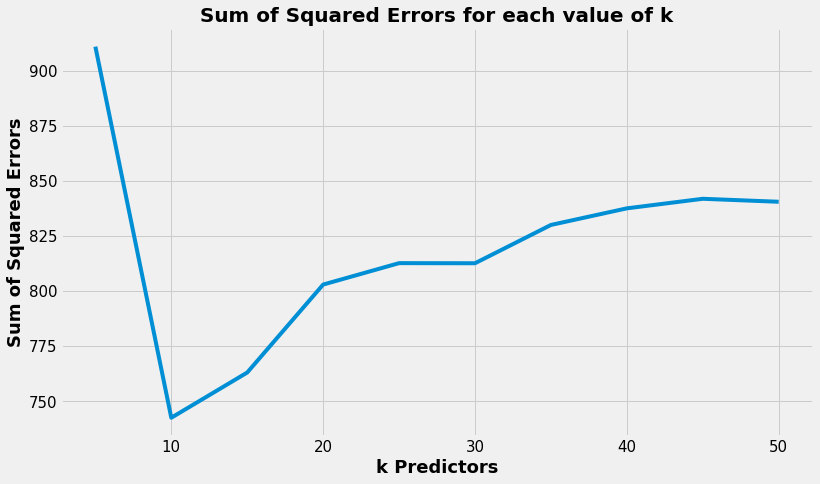

In [8]:
# Plot of k versus total sse for each value of k
plt.plot(k_dict.keys(), k_dict.values())
plt.xlabel('k Predictors')
plt.ylabel('Sum of Squared Errors')
plt.title('Sum of Squared Errors for each value of k')
plt.show()

#### Retrieve Optimal k, and Fit MIQP Model on Full Training Set

In [9]:
# From k_dict, gets the lowest value of SSE and the corresponding k
min_sse = min(k_dict.values())
min_k = min(k_dict, key = k_dict.get)

print('The minimum SSE is associated with' + ' k = ' + str(min_k) + '.')

The minimum SSE is associated with k = 10.


#### Non-Zero MIQP Betas

In [10]:
# Display the non-zero betas in the MIQP model
preds, sse, miqp_betas = solve_gurobi(train, test, min_k)
miqp_betas_df = pd.DataFrame(miqp_betas, index = ['Intercept'] + list(train.columns[1:]), columns = ['Beta'])
miqp_betas_df[miqp_betas_df['Beta'] != 0]

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-09


,Beta
Intercept,0.972524
X9,-2.308207
X15,-0.518326
X16,-0.204162
X23,-1.559143
X24,0.866973
X26,-1.311919
X34,0.408165
X45,1.781475
X47,0.887383


#### Performance Metrics for MIQP Model

In [11]:
# Using optimal k in the gurobi model to get the test SSE, test MSE, and the test r2
y_test = test['y']
miqp_mse = sse / test.shape[0]
miqp_r2 = sklearn.metrics.r2_score(y_test, preds)
# Adjusted R2
miqp_adj_r2 = 1 - (1 - miqp_r2) * (test.shape[0] - 1) / (test.shape[0] - int(min_k) - 1)


print()
print('MIQP Results with' + ' k = ' + str(min_k) + ':')
print()
print("MIQP Test SSE: ", round(sse, 5))
print("MIQP Test MSE: ", round(miqp_mse, 5))
print("MIQP Test R2: ", round(miqp_r2, 5))
print("MIQP Test Adjusted R2: ", round(miqp_adj_r2, 5))


MIQP Results with k = 10:

MIQP Test SSE:  116.8272
MIQP Test MSE:  2.33654
MIQP Test R2:  0.85867
MIQP Test Adjusted R2:  0.82243


<br>

### **Problem 2: Indirect Variable Selection (LASSO)**

LASSO Objective Function: 
$$min_{\beta} \sum_{i = 1}^{n} (\beta_{0}\, +\, \beta _{1}x_{i1}\, +\, ...\, \, \beta _{m}x_{im}\, -\, y_{i})^{2}\; +\; \lambda \sum_{j = 1}^{m}\left | \beta _{j} \right |$$


In [12]:
# Establish train and test data
X_train = train.drop(['y'], axis = 1)
y_train = train['y']
X_test = test.drop(['y'], axis = 1)
y_test = test['y']

# Vector of lambdas to cross validate
lambdas = 10 ** np.linspace(6, -6, 10000)

# Cross-validation with 10 folds
lasso_cv = LassoCV(cv = 10, alphas = lambdas, max_iter = 10000, normalize = True).fit(X_train, y_train)
best_lambda = lasso_cv.alpha_
print("Best lambda LassoCV: ", round(best_lambda, 5))

# Get intercept and append to list of LASSO coefficients
lasso_intercept = lasso_cv.intercept_
lasso_coeffs = list(lasso_cv.coef_)
lasso_coeffs.insert(0, lasso_intercept)

# Create data frame of coefficients
lasso_betas_df = pd.DataFrame(lasso_coeffs, index = ['Intercept'] + list(train.columns[1:]), columns = ['Beta'])
print()
non_zero_lasso_coefs = (lasso_betas_df['Beta'] != 0).sum() - 1
print("Number of Non-zero Coefficients (Excluding Intercept):", non_zero_lasso_coefs)
print()
lasso_betas_df[lasso_betas_df['Beta'] != 0]

Best lambda LassoCV:  0.00558

Number of Non-zero Coefficients (Excluding Intercept): 18



,Beta
Intercept,1.005255
X9,-2.120954
X11,-0.062870
X15,-0.417748
X16,-0.181649
X22,-0.196863
X23,-1.366855
X24,0.736951
X26,-1.301014
X29,0.062991


#### Plots for LASSO Model

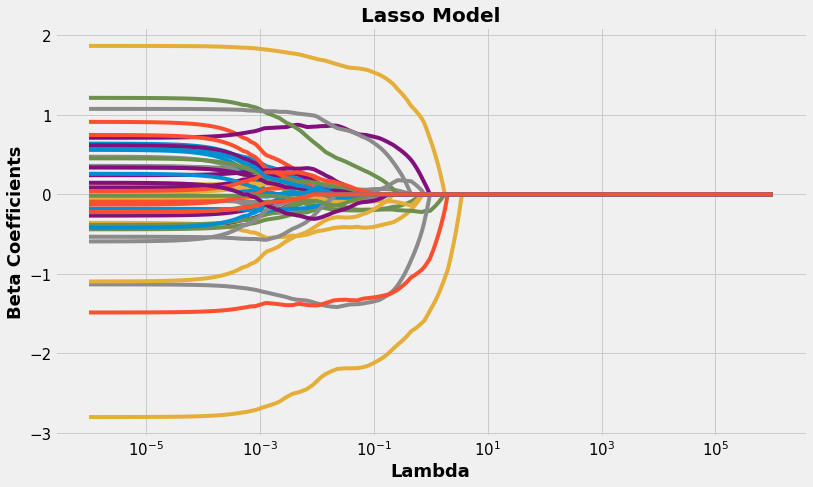

In [13]:
# Smaller range of lambas for ease of plotting 
alpha = 10 ** np.linspace(6,-6,1000) 

# Getting the lasso coefficients
lasso_coefficients = []

# Dictionaries to store train SSE and train MSE
sse = {}
mse = {}

# Loop through all values of alpha/lambda
for value in alpha:

    # Fit lasso model with that lambda on training data
    lasso_model = sklearn.linear_model.Lasso(alpha = value).fit(X_train, y_train)

    # Append those coefficients
    lasso_coefficients.append(lasso_model.coef_)
    
    # Get the training predictions
    y_train_pred = lasso_model.predict(X_train)
    
    # Calculate and store the training SSE 
    sse[value] = sum((y_train - y_train_pred) ** 2)
    
    # Calculate and store the training MSE
    mse[value] = sklearn.metrics.mean_squared_error(y_train, y_train_pred)
    
# Plot the lasso coefficients vs. lambda values
plt.plot(alpha, lasso_coefficients)
colNames = list(X_train.columns)
plt.title("Lasso Model")
plt.xlabel("Lambda")
plt.ylabel("Beta Coefficients")
plt.xscale("log")

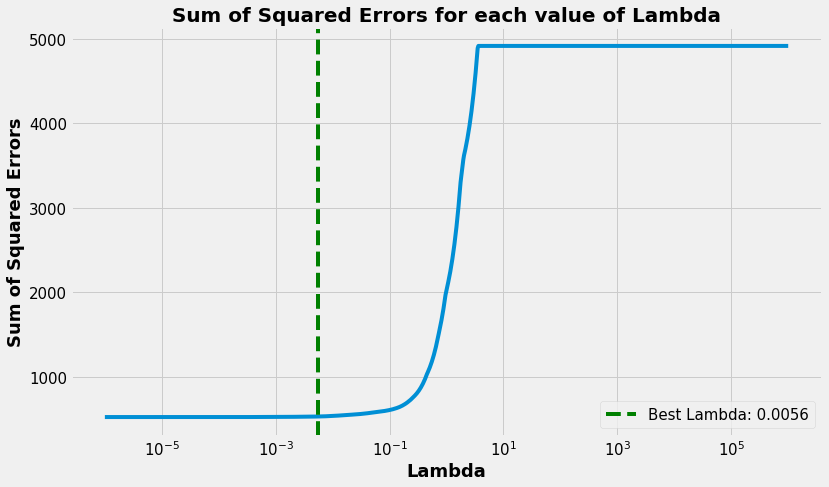

In [14]:
# Plot training SSE vs. alpha values in sse_dict
plt.plot(sse.keys(), sse.values())
plt.xlabel('Lambda')
plt.ylabel('Sum of Squared Errors')
plt.axvline(best_lambda, linestyle = '--', color = 'green', label = 'Best Lambda: ' + str(round(best_lambda, 4)))
plt.legend(loc = 'lower right')
plt.title('Sum of Squared Errors for each value of Lambda')
plt.xscale('log')
plt.show()

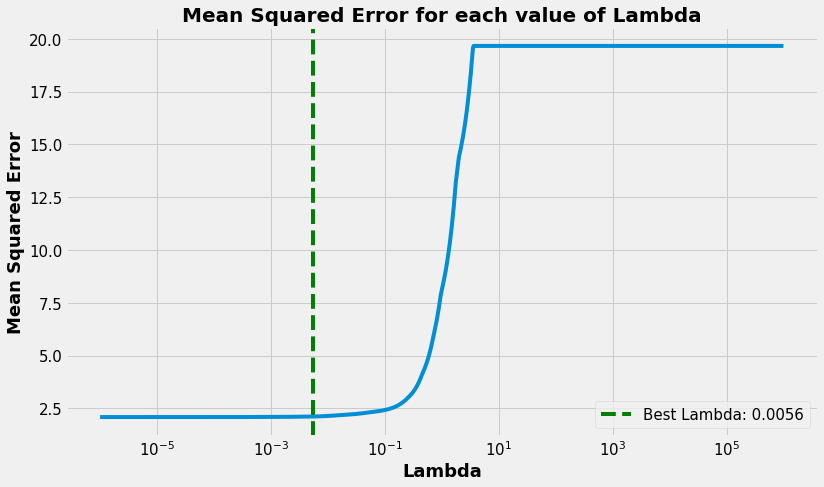

In [15]:
# Plot training MSE vs. lambda values in mse_dict
plt.plot(mse.keys(), mse.values())
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.axvline(best_lambda, linestyle = '--', color = 'green', label = 'Best Lambda: ' + str(round(best_lambda, 4)))
plt.legend(loc = 'lower right')
plt.title('Mean Squared Error for each value of Lambda')
plt.xscale('log')

#### Comparison of Model Coefficients

In [16]:
# Combining the two data frames of betas
betas_df = pd.concat([miqp_betas_df, lasso_betas_df], axis = 1)
betas_df.columns = ['MIQP', 'LASSO']
betas_df

,MIQP,LASSO
Intercept,0.972524,1.005255
X1,0.000000,-0.000000
X2,0.000000,-0.000000
X3,0.000000,0.000000
X4,0.000000,0.000000
X5,0.000000,-0.000000
X6,0.000000,0.000000
X7,0.000000,-0.000000
X8,0.000000,-0.000000
X9,-2.308207,-2.120954


#### Performance Metrics - LASSO

In [17]:
# Getting test MSE for optimal LASSO model
test_pred = lasso_cv.predict(X_test)
lasso_test_mse = sklearn.metrics.mean_squared_error(y_test, test_pred)
# R2 and Adj R2 for optimal LASSO model
lasso_r2 = sklearn.metrics.r2_score(y_test, test_pred) 
lasso_adj_r2 = 1 - (1 - lasso_r2) * (len(y_test) - 1) / (len(y_test) - non_zero_lasso_coefs - 1)

# Print results
print()
print('LASSO Results with' + ' lambda = ' + str(round(best_lambda, 5)) + ':')
print()
print("Optimal Lambda: ", round(best_lambda, 5))
print("LASSO Test MSE: ", format(lasso_test_mse, '.5f'))
print("LASSO Test R2: ", format(lasso_r2, '.5f'))
print("LASSO Test Adj R2: ", format(lasso_adj_r2, '.5f'))
print()


LASSO Results with lambda = 0.00558:

Optimal Lambda:  0.00558
LASSO Test MSE:  2.35832
LASSO Test R2:  0.85735
LASSO Test Adj R2:  0.77452



#### Performance Metrics Comparison - MIQP vs. LASSO

In [18]:
# Performance metrics for MIQP and LASSO
index = ['MIQP', 'LASSO']
results = pd.DataFrame({'Test MSE': [miqp_mse, lasso_test_mse], 'Test R2': [miqp_r2, lasso_r2], 'Adj R2' : [miqp_adj_r2, lasso_adj_r2]}, index = index)
results

,Test MSE,Test R2,Adj R2
MIQP,2.336544,0.858668,0.822429
LASSO,2.358319,0.857351,0.774523
